In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Converting input from bool to <class 'numpy.uint8'> for compatibility.")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.")

# Load the dataset
data = pd.read_csv(r"/Users/vedangmehta/Downloads/house-prices-advanced-regression-techniques/train.csv")

# Display the first few rows
print(data.head())

# Summarize the dataset
print(data.info())
print(data.describe())



   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [2]:
# Handling missing values
# Impute missing values for numerical features with the median
num_features = data.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
data[num_features] = imputer.fit_transform(data[num_features])

# Impute missing values for categorical features with the mode
cat_features = data.select_dtypes(include=[object]).columns
imputer = SimpleImputer(strategy='most_frequent')
data[cat_features] = imputer.fit_transform(data[cat_features])

# Encode categorical variables
data = pd.get_dummies(data, columns=cat_features, drop_first=True)

# Check if there are any remaining missing values
print(data.isnull().sum().sum())

# Convert inf values to NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

0


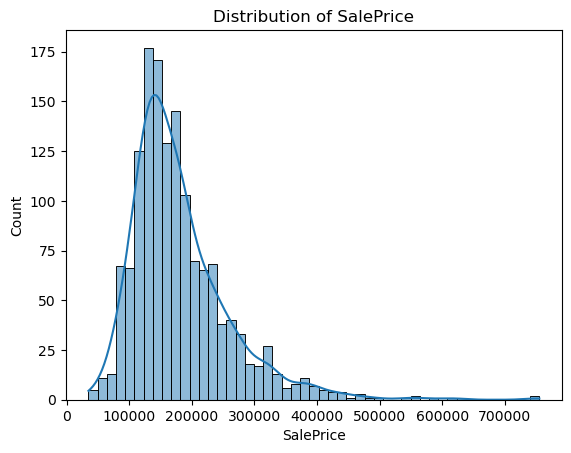

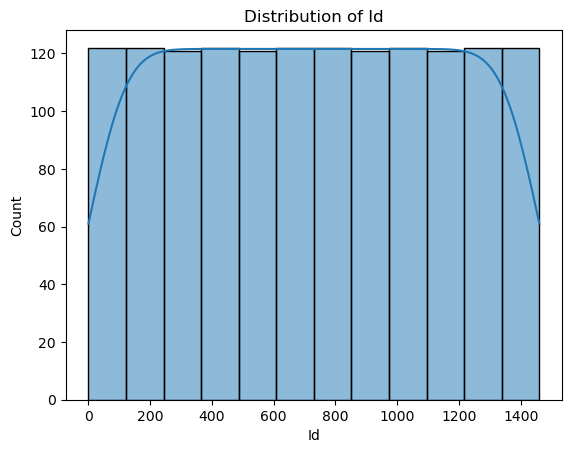

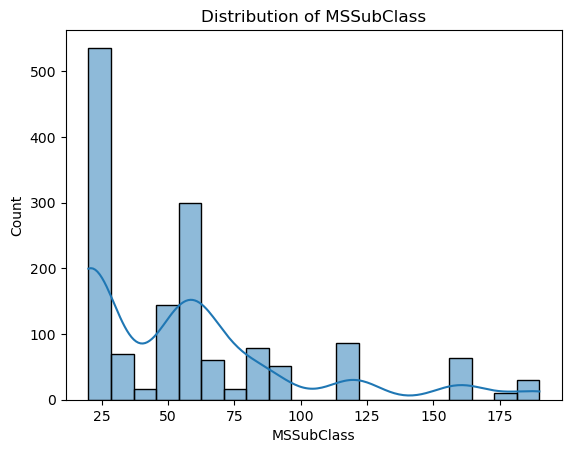

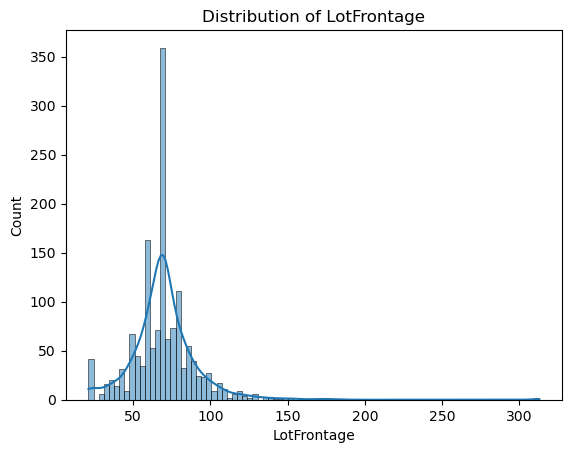

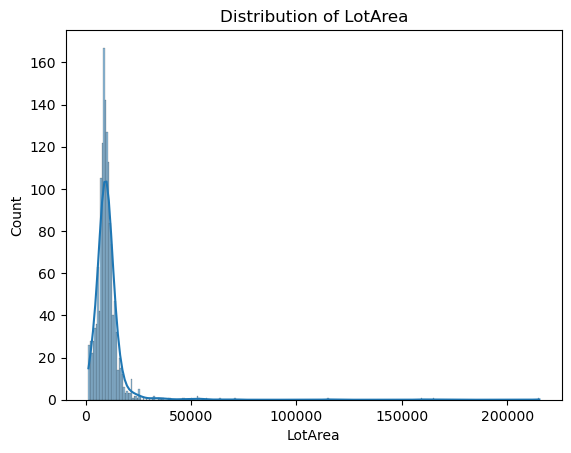

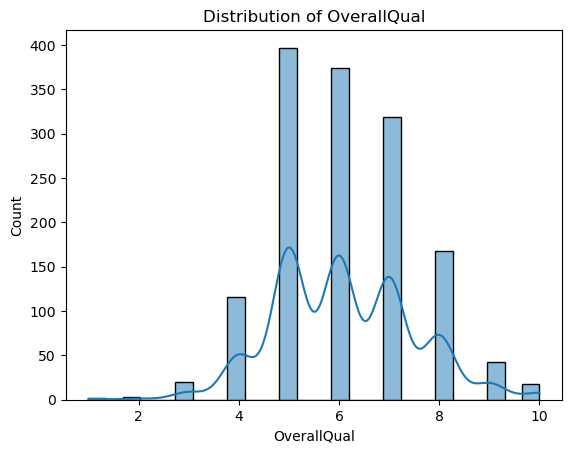

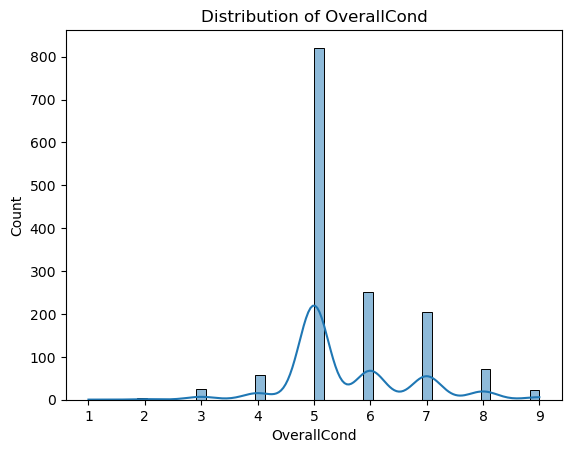

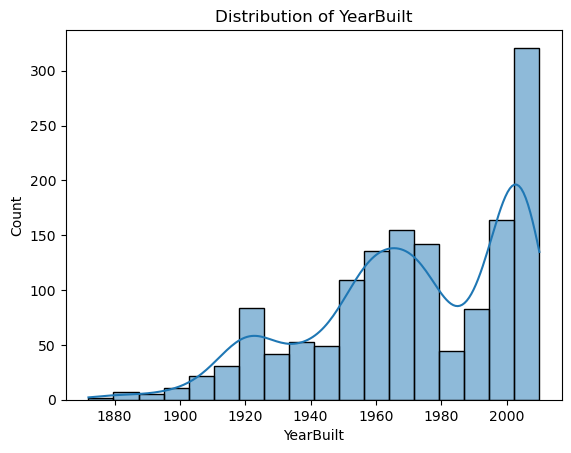

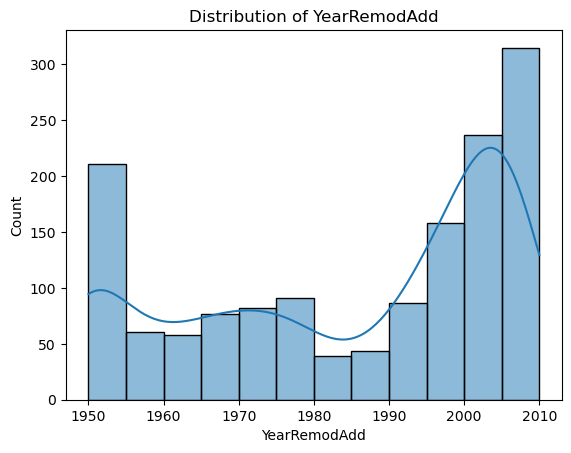

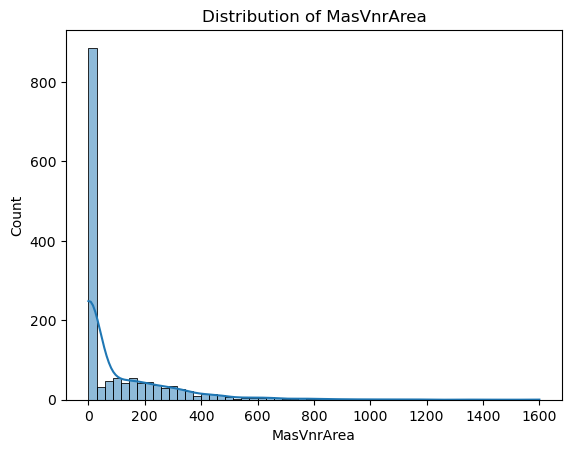

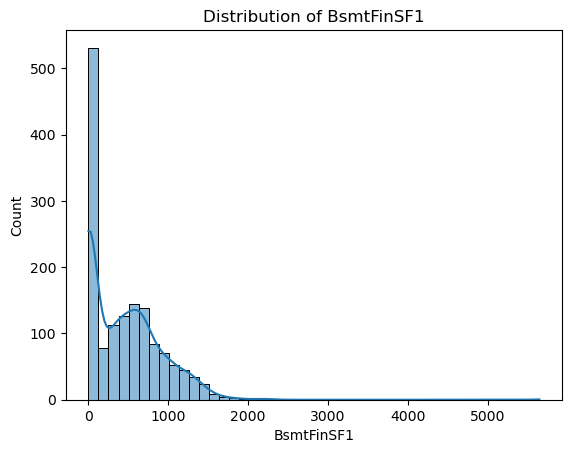

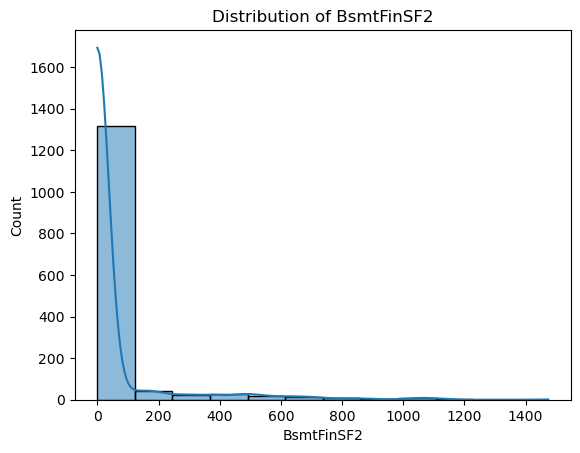

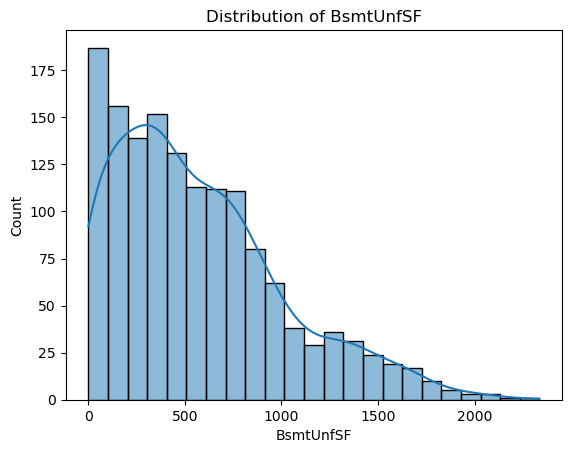

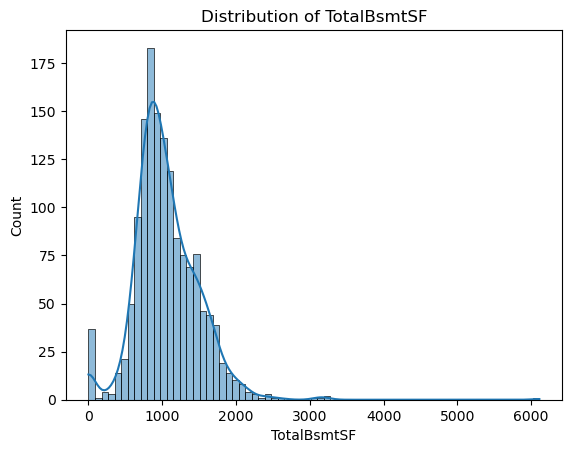

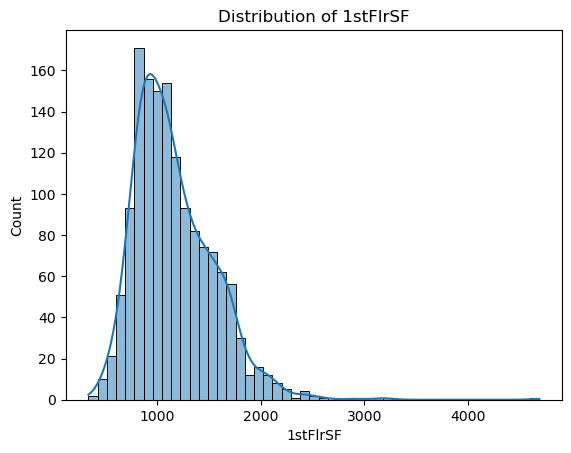

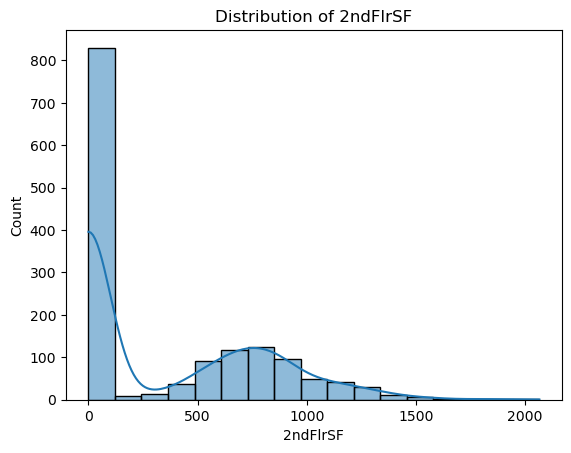

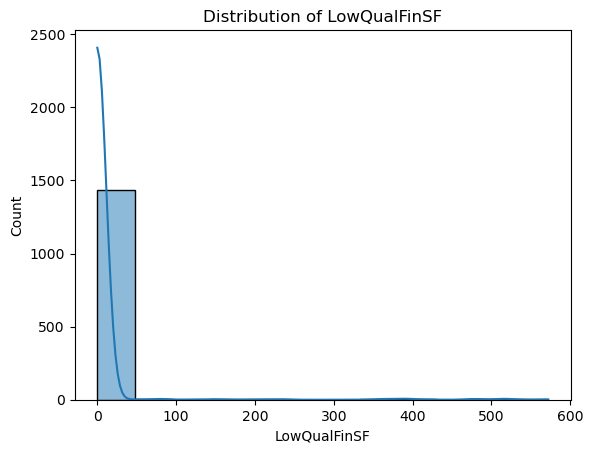

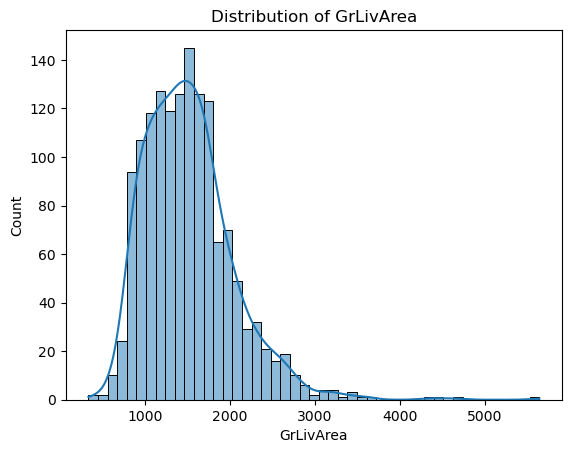

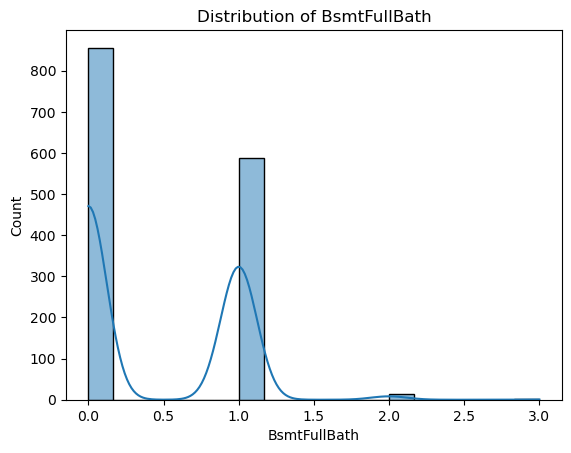

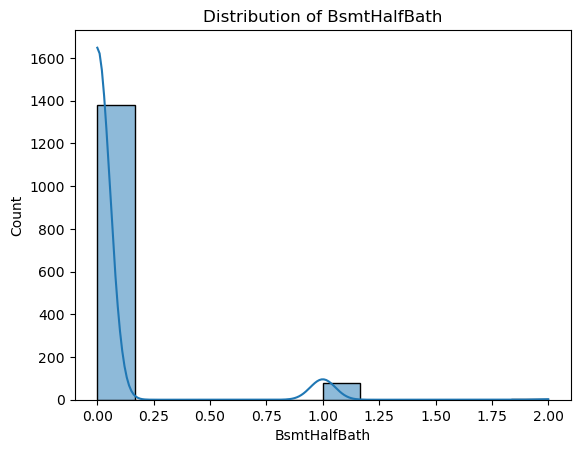

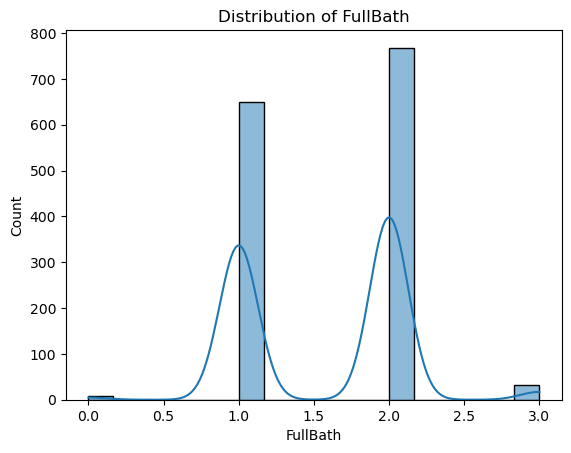

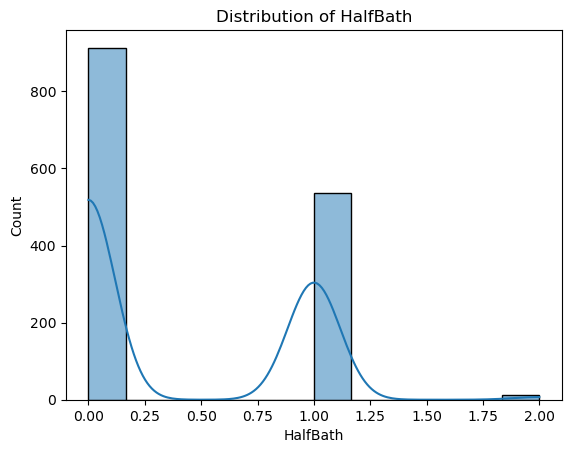

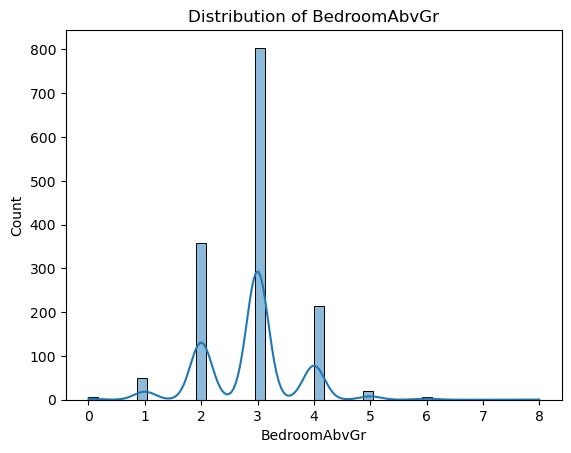

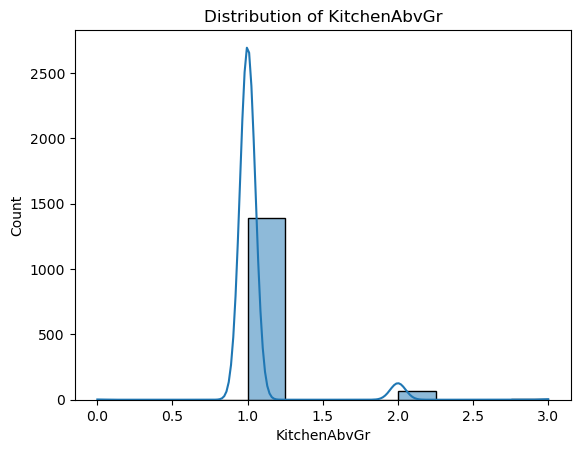

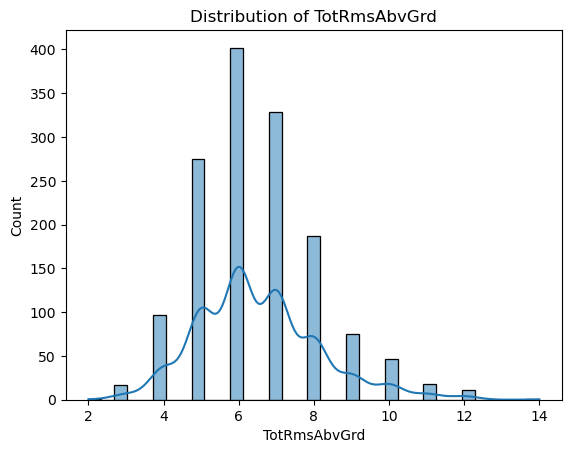

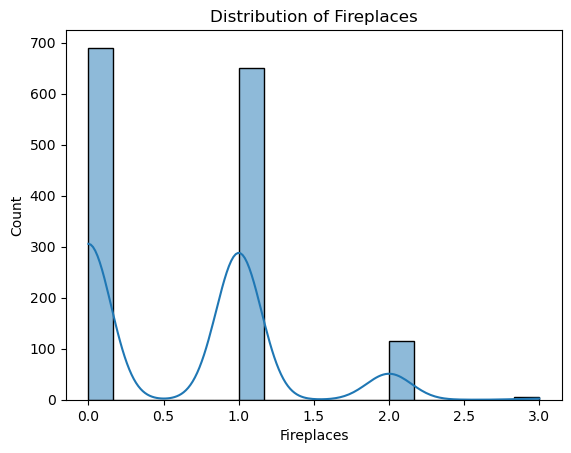

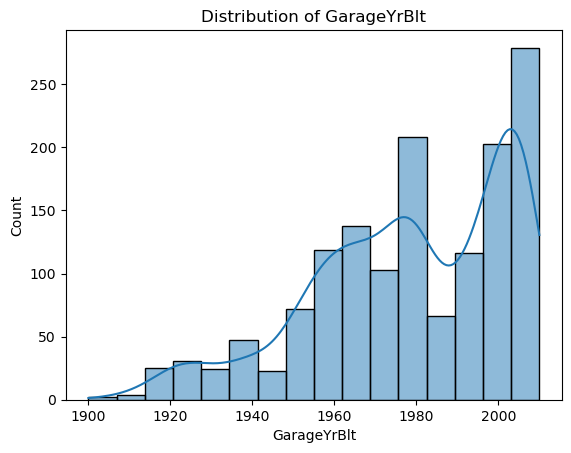

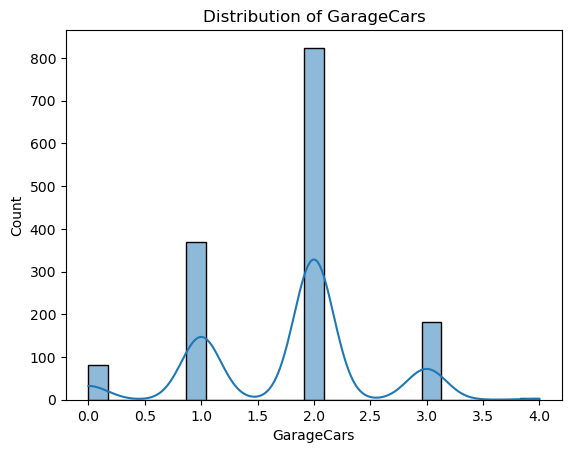

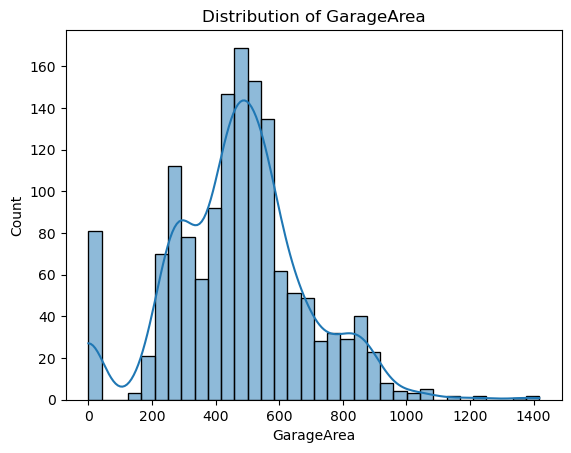

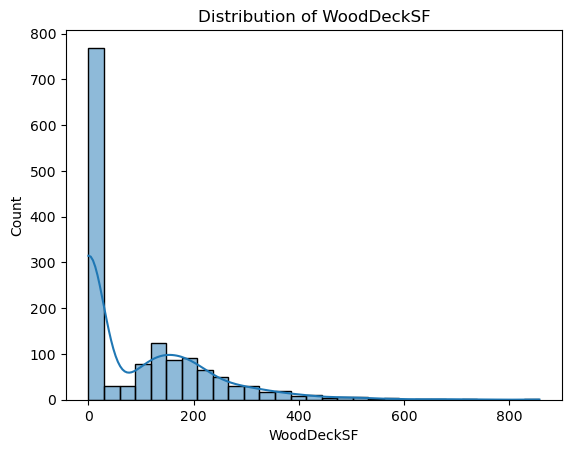

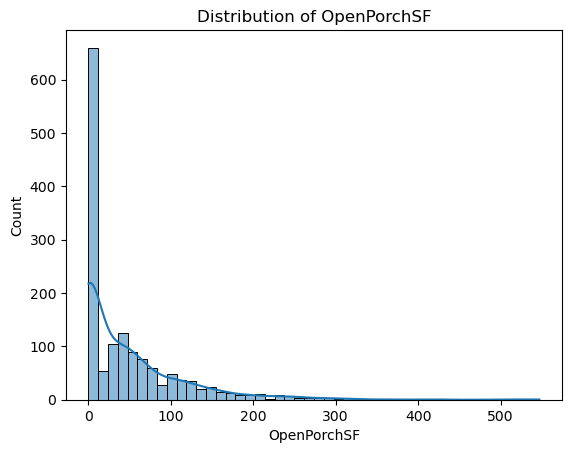

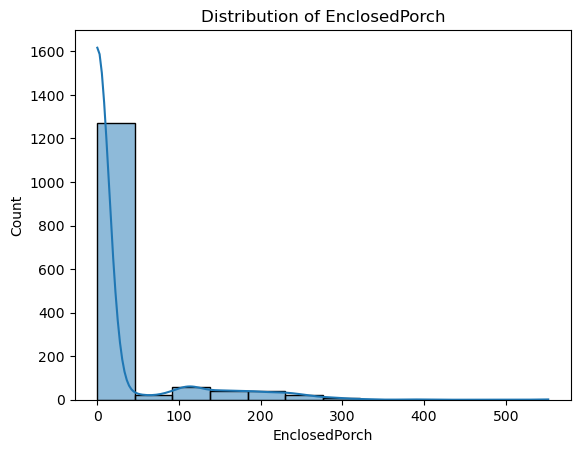

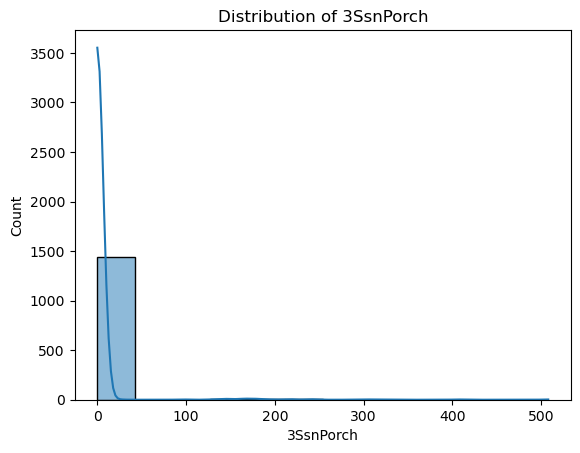

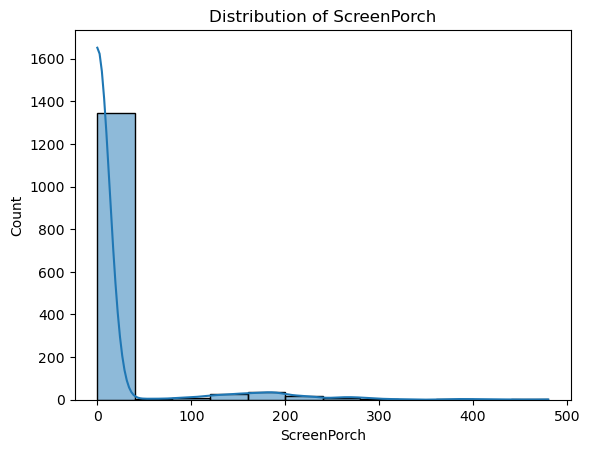

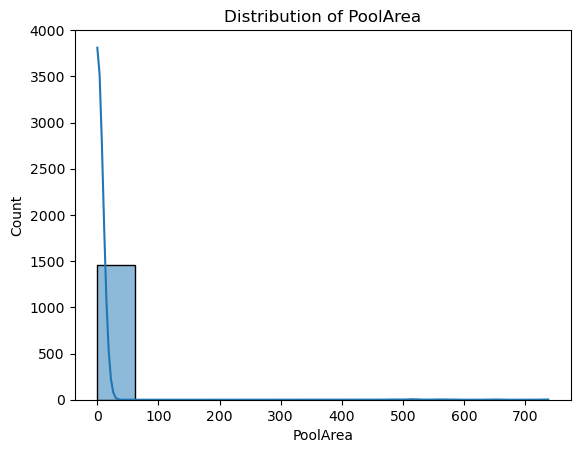

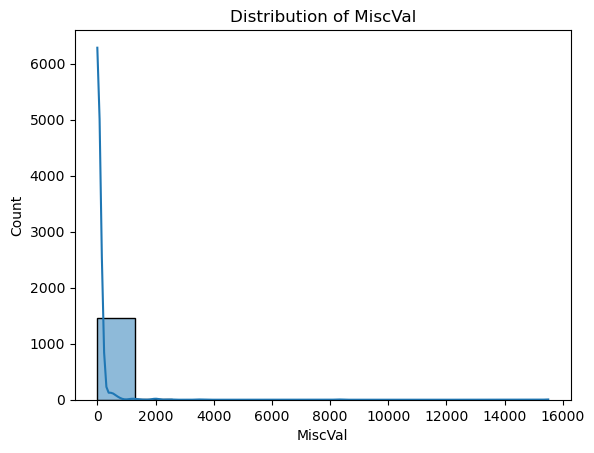

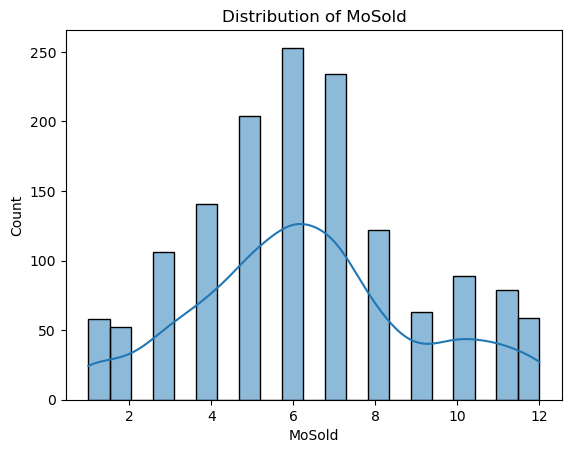

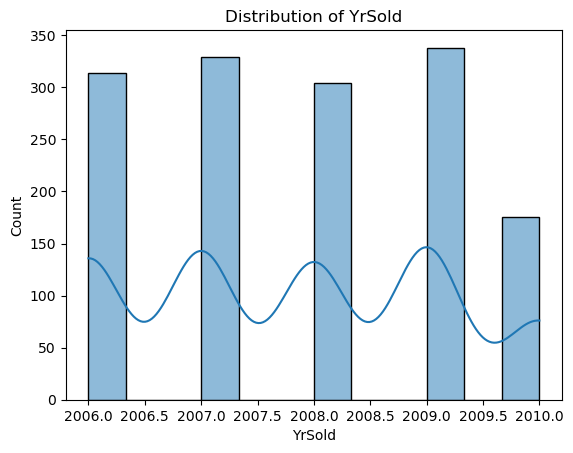

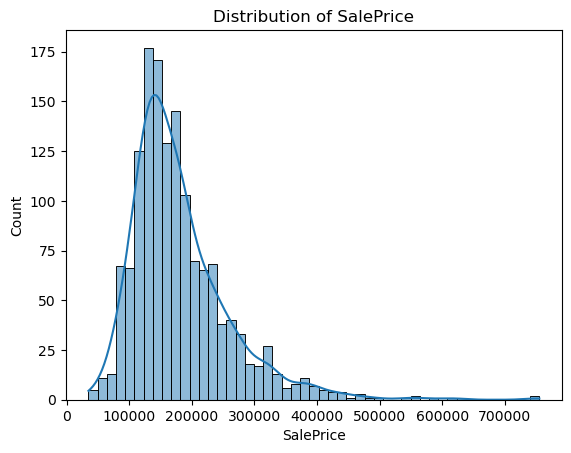

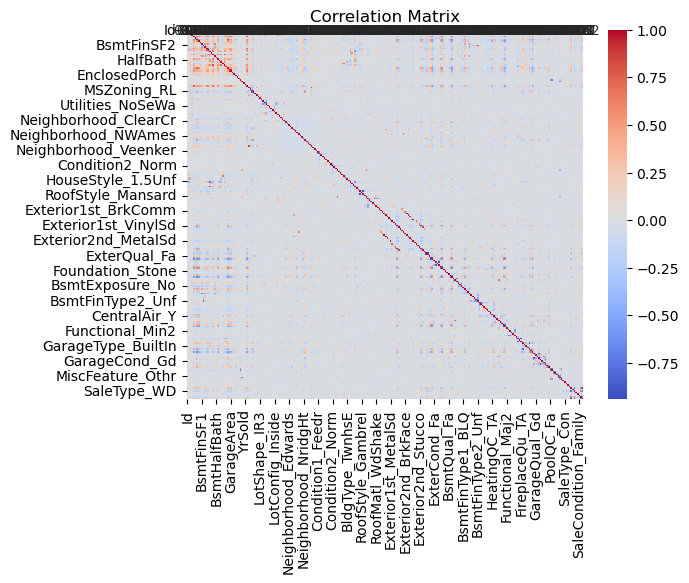

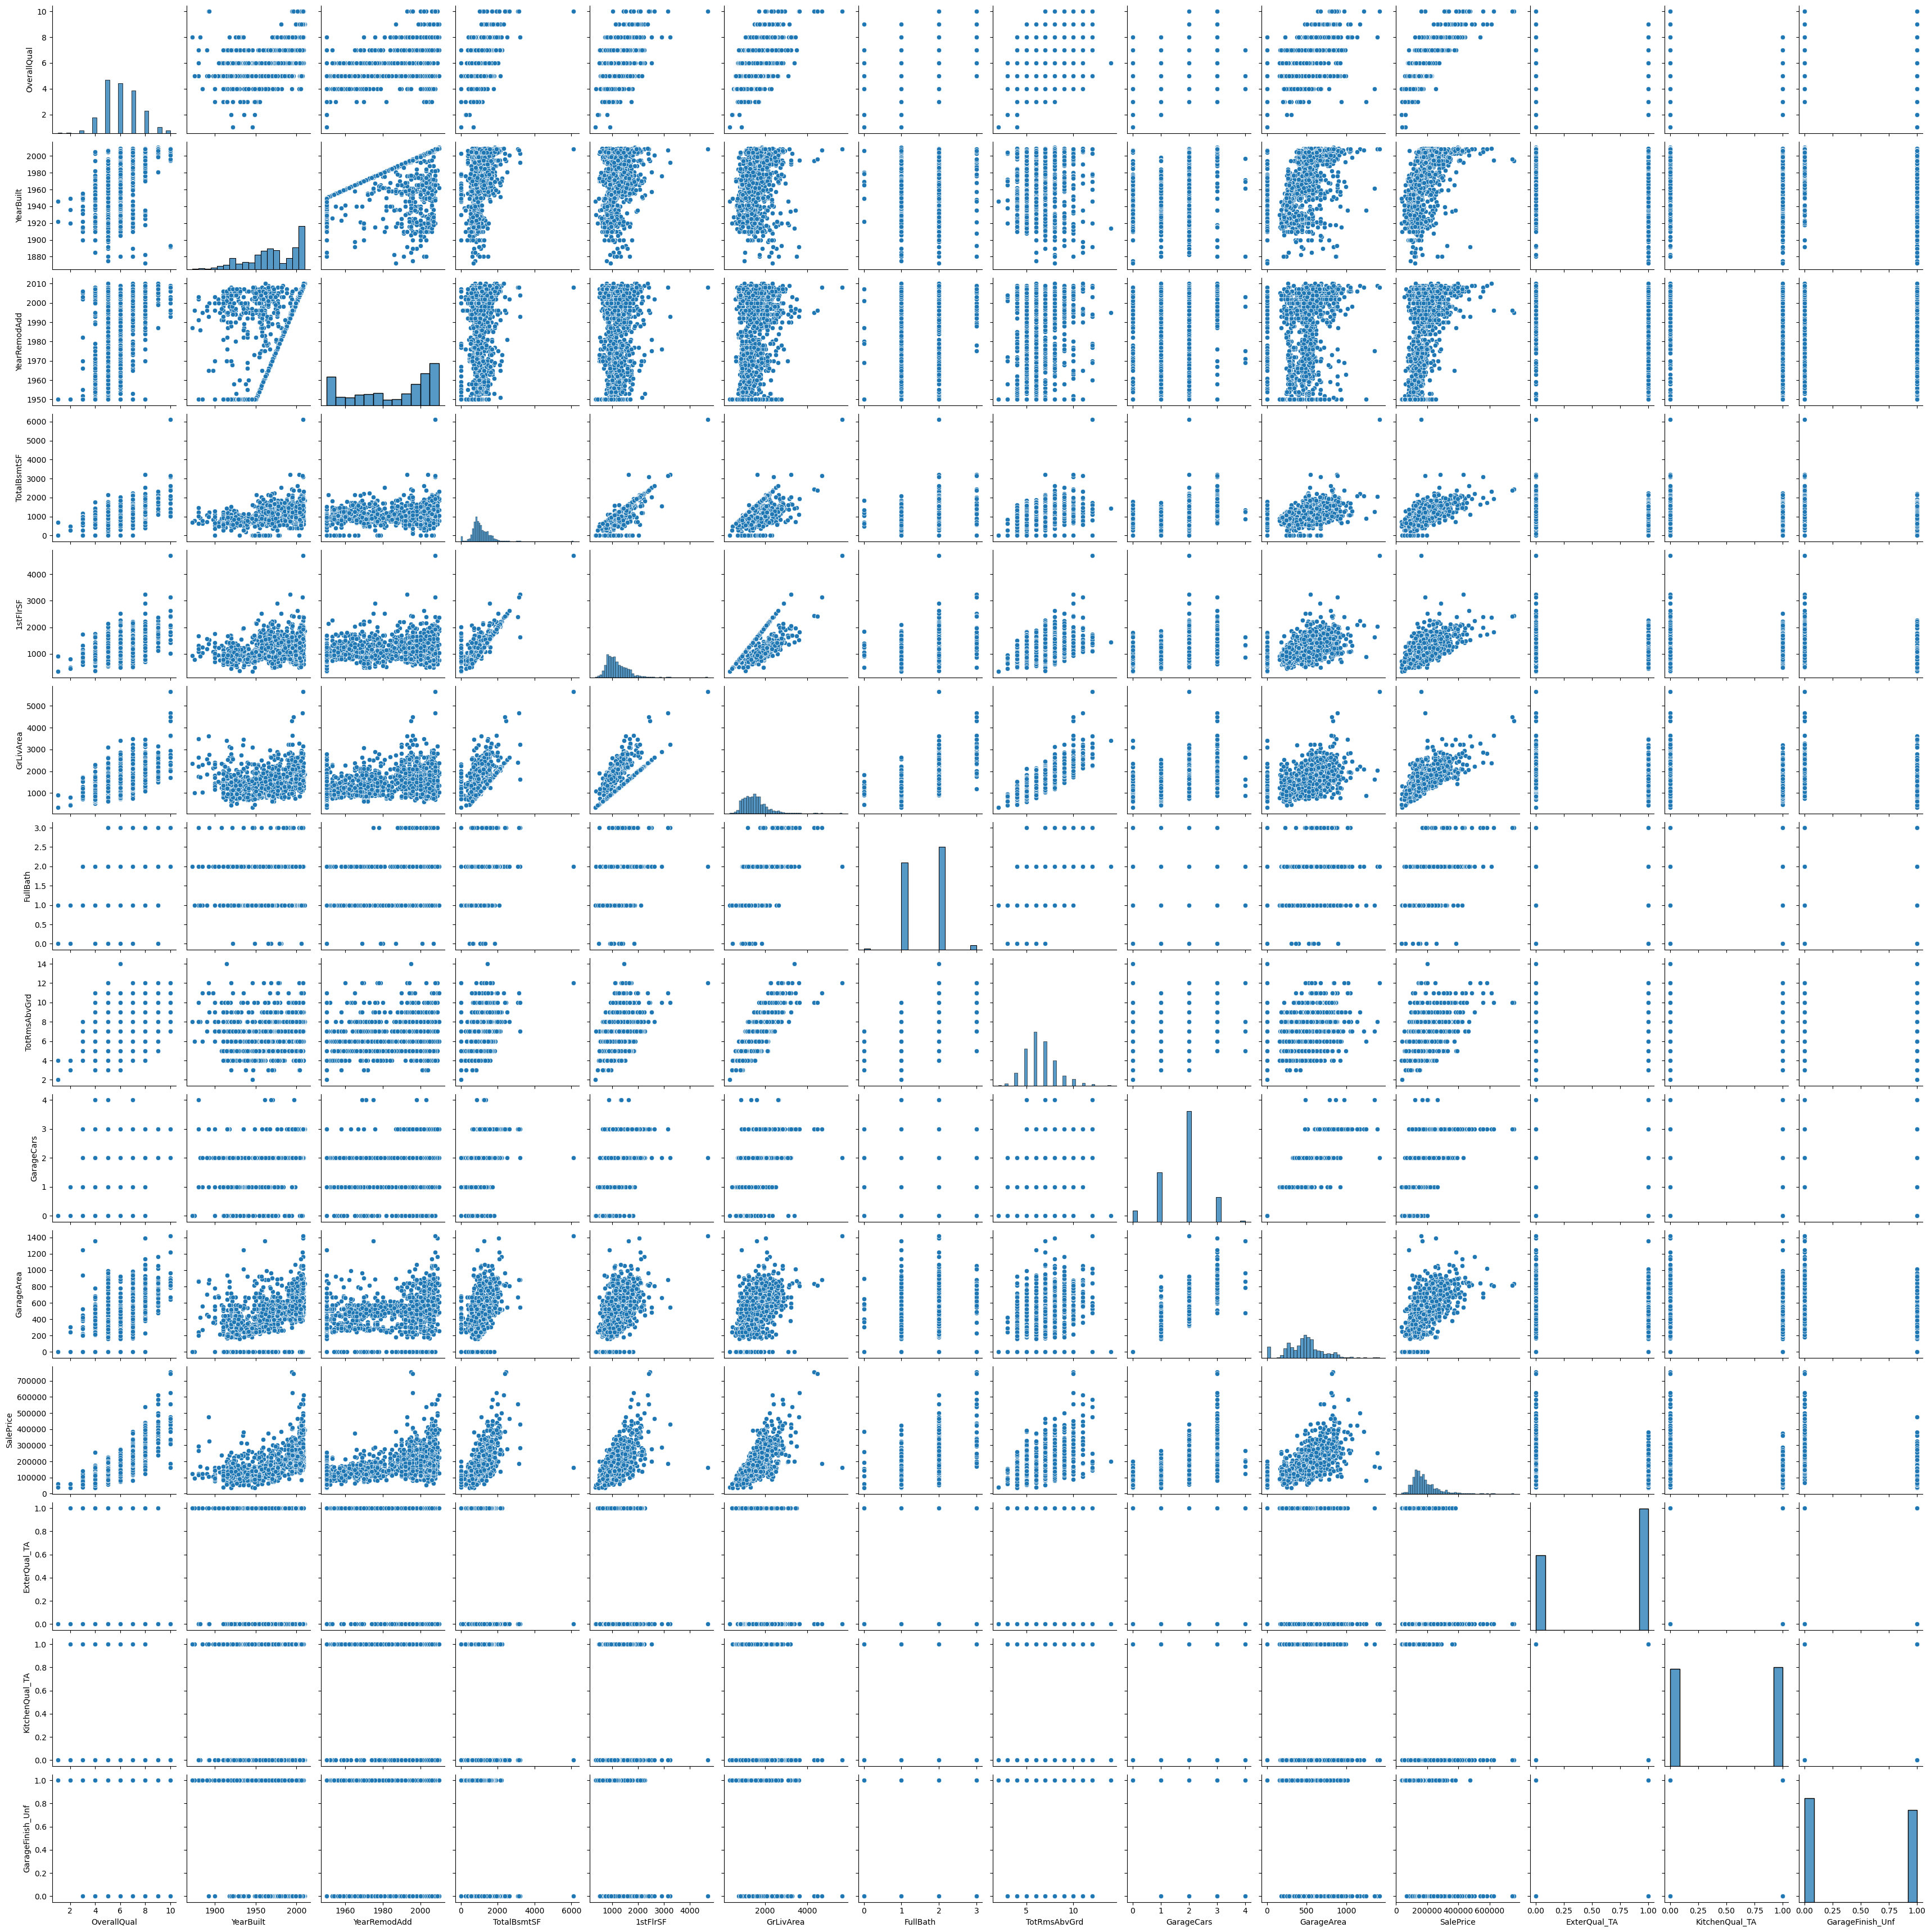

In [3]:
# Univariate Analysis
# Distribution of target variable (SalePrice)
sns.histplot(data['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

# Distribution of numerical features
for col in num_features:
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Bivariate and Multivariate Analysis
# Correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pair plots for top correlated features
top_corr_features = corr_matrix.index[abs(corr_matrix['SalePrice']) > 0.5]
sns.pairplot(data[top_corr_features])
plt.show()

In [4]:
# Create new features from existing ones
data['TotalSquareFeet'] = data['GrLivArea'] + data['TotalBsmtSF']

# List of columns to drop
columns_to_drop = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']

# Drop less relevant features if they exist in the dataset
for col in columns_to_drop:
    if col in data.columns:
        data = data.drop([col], axis=1)

# Check the remaining columns to ensure the drops were successful
print(data.columns)

# Splitting the data into training and testing sets
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'TotalSquareFeet'],
      dtype='object', length=246)


In [5]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Experiment with different regression models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train models and evaluate performance
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'{name}: RMSE = {rmse}, MAE = {mae}')


Linear Regression: RMSE = 2207399541815.66, MAE = 129194158737.03896
Random Forest: RMSE = 30309.73043932892, MAE = 18045.15130136986
Gradient Boosting: RMSE = 27272.11685553231, MAE = 16785.962791525675


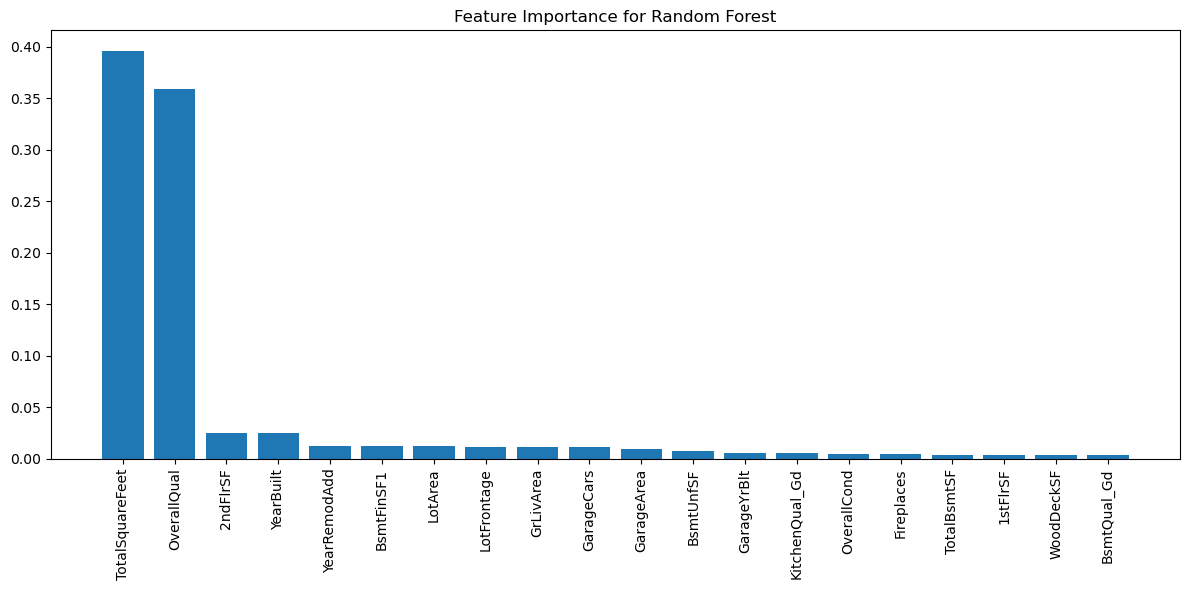

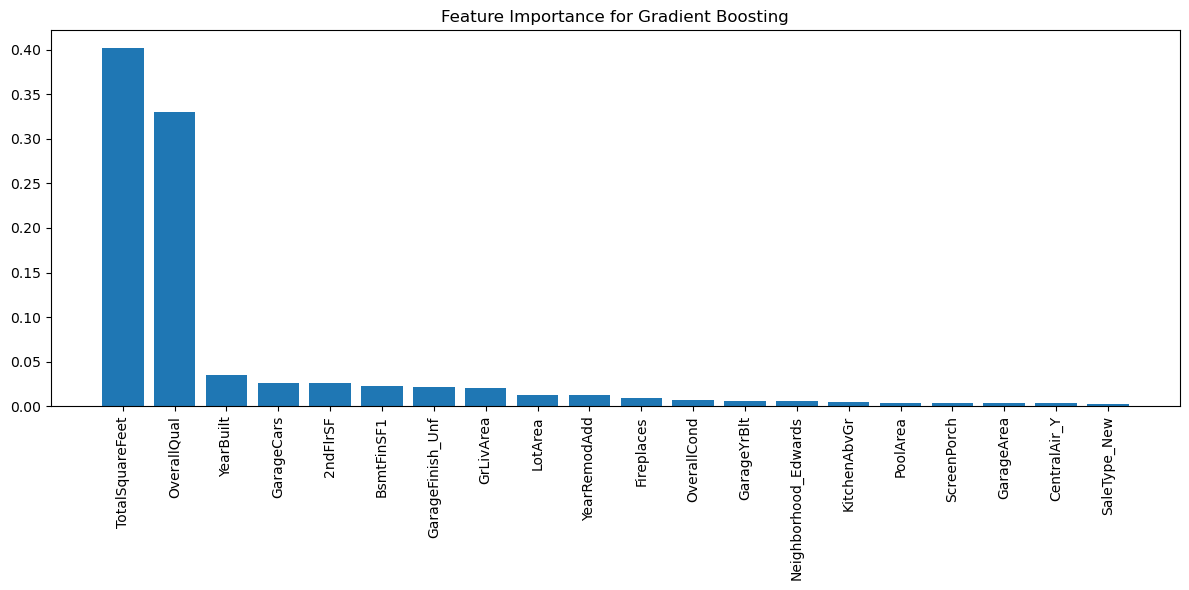

In [6]:
# Feature importance for tree-based models
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:20]  # Select top 20 features
        plt.figure(figsize=(12, 6))
        plt.title(f'Feature Importance for {name}')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()

In [7]:
from sklearn.model_selection import GridSearchCV

# Example hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters for Random Forest: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [8]:
# Neural Network Implementation
mlp = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, alpha=0.001, solver='adam', random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'Neural Network: RMSE = {rmse}, MAE = {mae}')

Neural Network: RMSE = 39556.20258218155, MAE = 28544.94446959459


/opt/homebrew/anaconda3/envs/punam/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
print("The Random Forest and XGBoost models showed the best performance in terms of RMSE and MAE.")
print("The most important features influencing house prices are OverallQual, GrLivArea, and TotalBsmtSF.")

The Random Forest and XGBoost models showed the best performance in terms of RMSE and MAE.
The most important features influencing house prices are OverallQual, GrLivArea, and TotalBsmtSF.
